In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf 
print ("Done")

Done


In [3]:
#preparing data set


ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [4]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
    

In [5]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [6]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',
                             8:'Surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  Surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   Neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   Disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   Disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   Neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     Fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    Angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      Sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  Disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    Angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Surprise    192
Disgust     192
Fear        192
Sad         192
Calm        192
Happy       192
Angry       192
Neutral      96
Name: Emo

In [7]:
data,sr = librosa.load(file_path[0])
sr

22050

In [8]:
ipd.Audio(data,rate=sr)

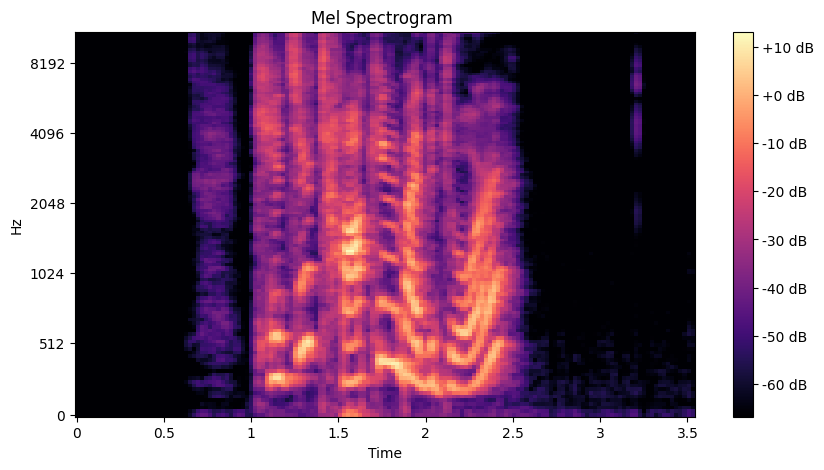

In [9]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

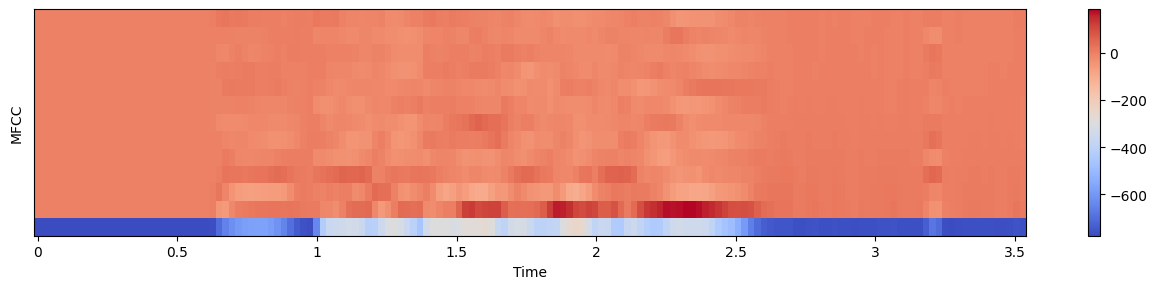

In [10]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

In [11]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sr, n_steps=0.05):
    return librosa.effects.pitch_shift(data, sr=22050, n_steps=0.05)

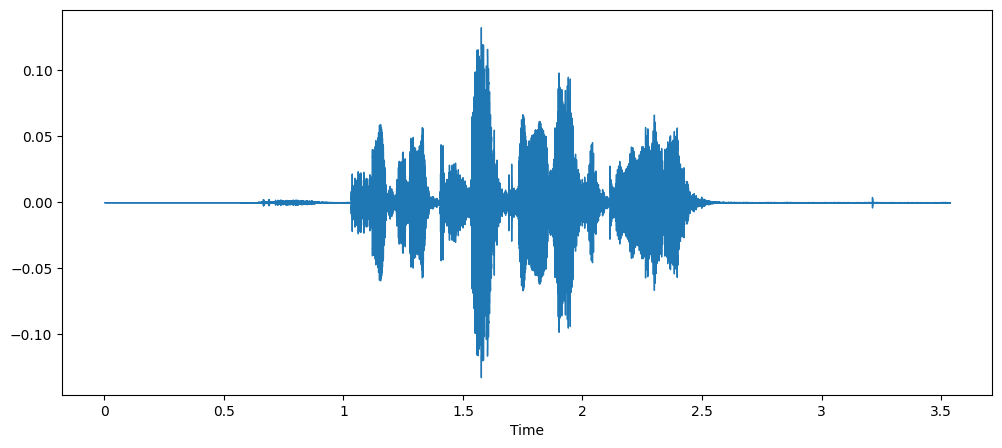

In [12]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

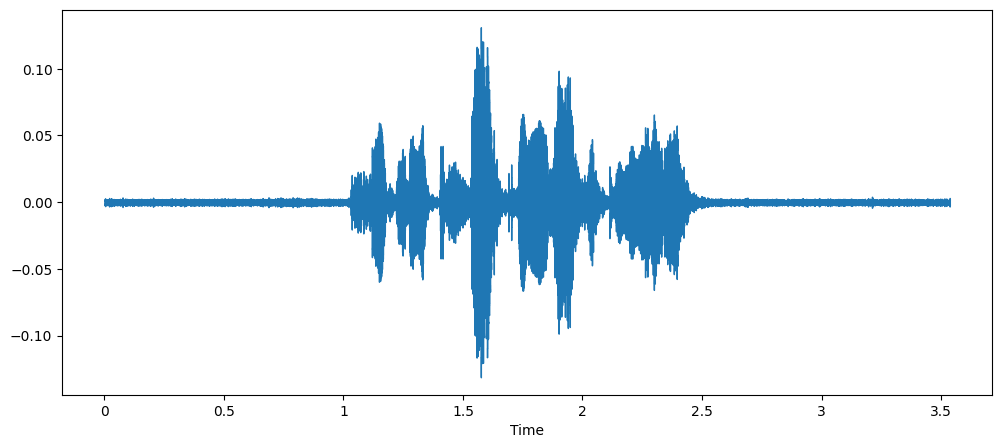

In [13]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

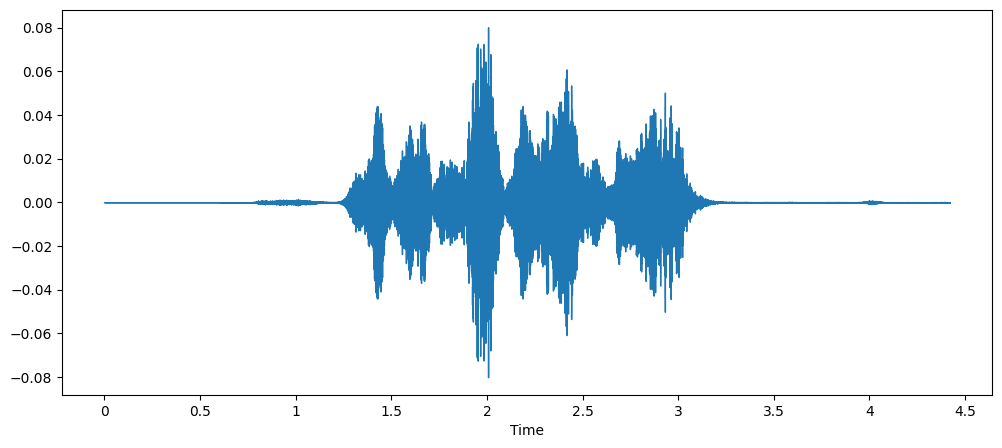

In [14]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

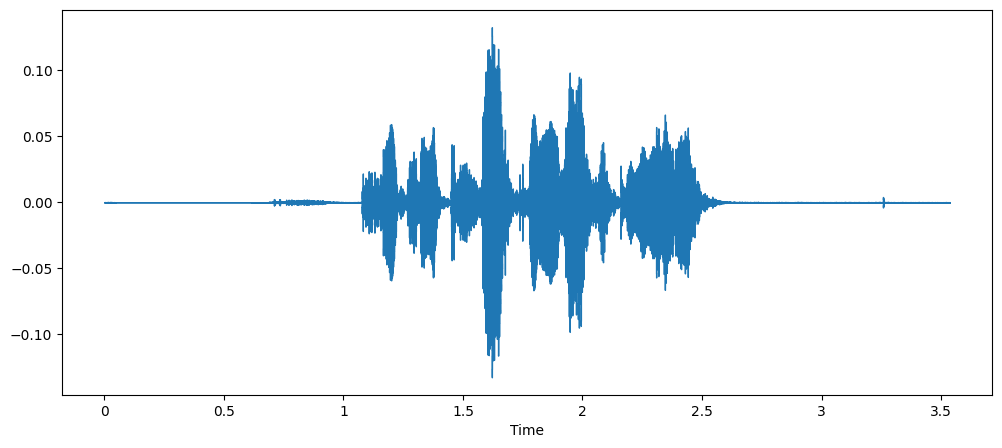

In [15]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

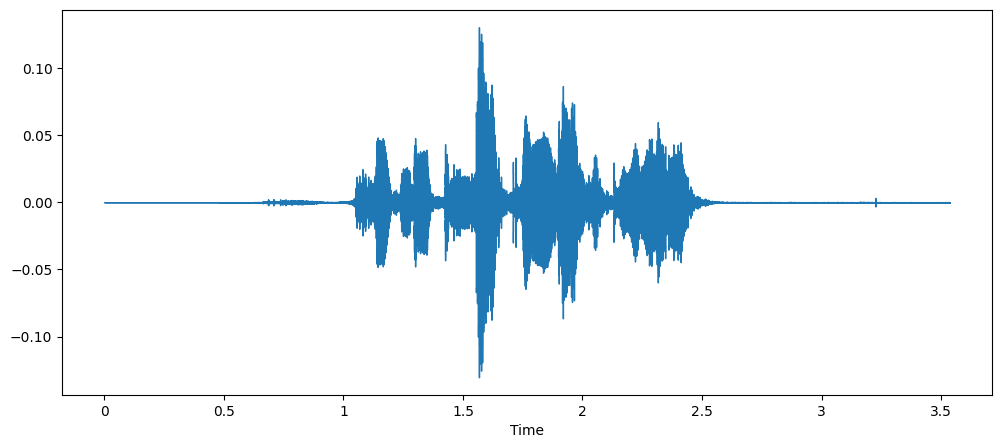

In [16]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [17]:
def feat_ext(data):
    mfccs = np.mean(librosa.feature.mfcc(y=data, n_mfcc=13, sr=sr).T,axis=0)
    #delta_mfccs = np.mean(librosa.feature.delta(mfccs).T,axis=0)
    #delta2_mfccs = np.mean(librosa.feature.delta(mfccs, order=2).T,axis=0)
    #mfccs_features = np.mean(np.concatenate((mfccs, delta_mfccs, delta2_mfccs)),axis=0)
    return mfccs

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result


In [18]:
X , Y = [], []
for path, emotion in zip(ravdess_df['Path'] , ravdess_df['Emotions']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [19]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Emotions
0,-498.172028,53.171146,-22.092066,11.496428,-10.811963,-12.038263,-5.335874,-8.586675,-4.736596,-5.701678,-6.475440,-6.314910,-5.045801,Surprise
1,-463.078603,44.657125,-20.317396,7.222437,-11.480234,-12.257418,-5.903642,-8.189334,-5.740028,-5.982103,-6.224033,-7.173413,-4.665424,Surprise
2,-540.399780,50.860722,-24.252686,10.049084,-14.145730,-14.017048,-7.353907,-8.790749,-6.207544,-5.760708,-7.100573,-6.272335,-5.654745,Surprise
3,-573.702881,74.766006,-16.835482,9.510839,-8.442752,-7.398401,-9.191017,-13.571818,-6.444541,-1.531598,-7.231005,-3.087768,-7.518959,Neutral
4,-491.585606,50.714287,-9.668853,2.843931,-7.688942,-8.038762,-9.277877,-12.605348,-7.270933,-2.561476,-4.306751,-5.412887,-5.047291,Neutral


In [20]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Emotions
0,-498.172028,53.171146,-22.092066,11.496428,-10.811963,-12.038263,-5.335874,-8.586675,-4.736596,-5.701678,-6.475440,-6.314910,-5.045801,Surprise
1,-463.078603,44.657125,-20.317396,7.222437,-11.480234,-12.257418,-5.903642,-8.189334,-5.740028,-5.982103,-6.224033,-7.173413,-4.665424,Surprise
2,-540.399780,50.860722,-24.252686,10.049084,-14.145730,-14.017048,-7.353907,-8.790749,-6.207544,-5.760708,-7.100573,-6.272335,-5.654745,Surprise
3,-573.702881,74.766006,-16.835482,9.510839,-8.442752,-7.398401,-9.191017,-13.571818,-6.444541,-1.531598,-7.231005,-3.087768,-7.518959,Neutral
4,-491.585606,50.714287,-9.668853,2.843931,-7.688942,-8.038762,-9.277877,-12.605348,-7.270933,-2.561476,-4.306751,-5.412887,-5.047291,Neutral


In [21]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [22]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [23]:
print(Y.shape)
X.shape

(4320, 8)


(4320, 13)

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 13), (3240, 8), (1080, 13), (1080, 8))

In [25]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [26]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 13), (3240, 8), (1080, 13), (1080, 8))

In [27]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [28]:
model01=Sequential()
model01.add(LSTM(70,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(LSTM(50,return_sequences=True))
model01.add(LSTM(60))
model01.add(Dense(8))
model01.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 70)            20160     
                                                                 
 lstm_1 (LSTM)               (None, 13, 50)            24200     
                                                                 
 lstm_2 (LSTM)               (None, 60)                26640     
                                                                 
 dense (Dense)               (None, 8)                 488       
                                                                 
Total params: 71,488
Trainable params: 71,488
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist=model01.fit(X_train, y_train,
            epochs=500,
            validation_data=(X_test, y_test),batch_size=65,
            verbose=1)

Epoch 1/500
50/50 [==============================] - 13s 32ms/step - loss: 0.1078 - accuracy: 0.1981 - val_loss: 0.1051 - val_accuracy: 0.2065
Epoch 2/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1042 - accuracy: 0.2552 - val_loss: 0.1036 - val_accuracy: 0.2176
Epoch 3/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1027 - accuracy: 0.2781 - val_loss: 0.1022 - val_accuracy: 0.2639
Epoch 4/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1020 - accuracy: 0.2824 - val_loss: 0.1017 - val_accuracy: 0.2833
Epoch 5/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1008 - accuracy: 0.3068 - val_loss: 0.1004 - val_accuracy: 0.3074
Epoch 6/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1003 - accuracy: 0.3071 - val_loss: 0.0996 - val_accuracy: 0.3111
Epoch 7/500
50/50 [==============================] - 1s 11ms/step - loss: 0.0988 - accuracy: 0.3238 - val_loss: 0.0985 - val_accuracy: 0.3361
Epoch

34/34 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.6426
Accuracy of our model on test data :  64.25926089286804 %


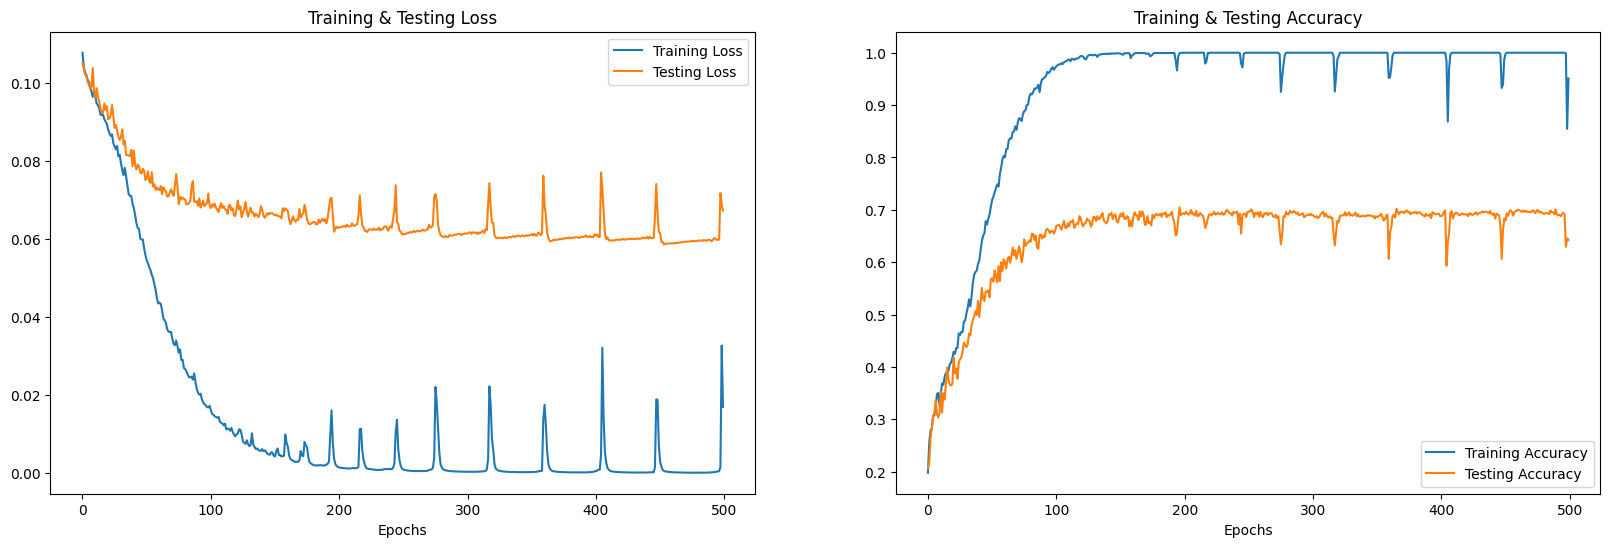

In [30]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(500)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [31]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 13, 1), (3240, 8), (1080, 13, 1), (1080, 8))

Multi_model (CNN_LSTM)


In [32]:
#CNN


model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 2048)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 2048)          8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 1024)           10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 1024)          0         
 1D)                                                             
                                                      

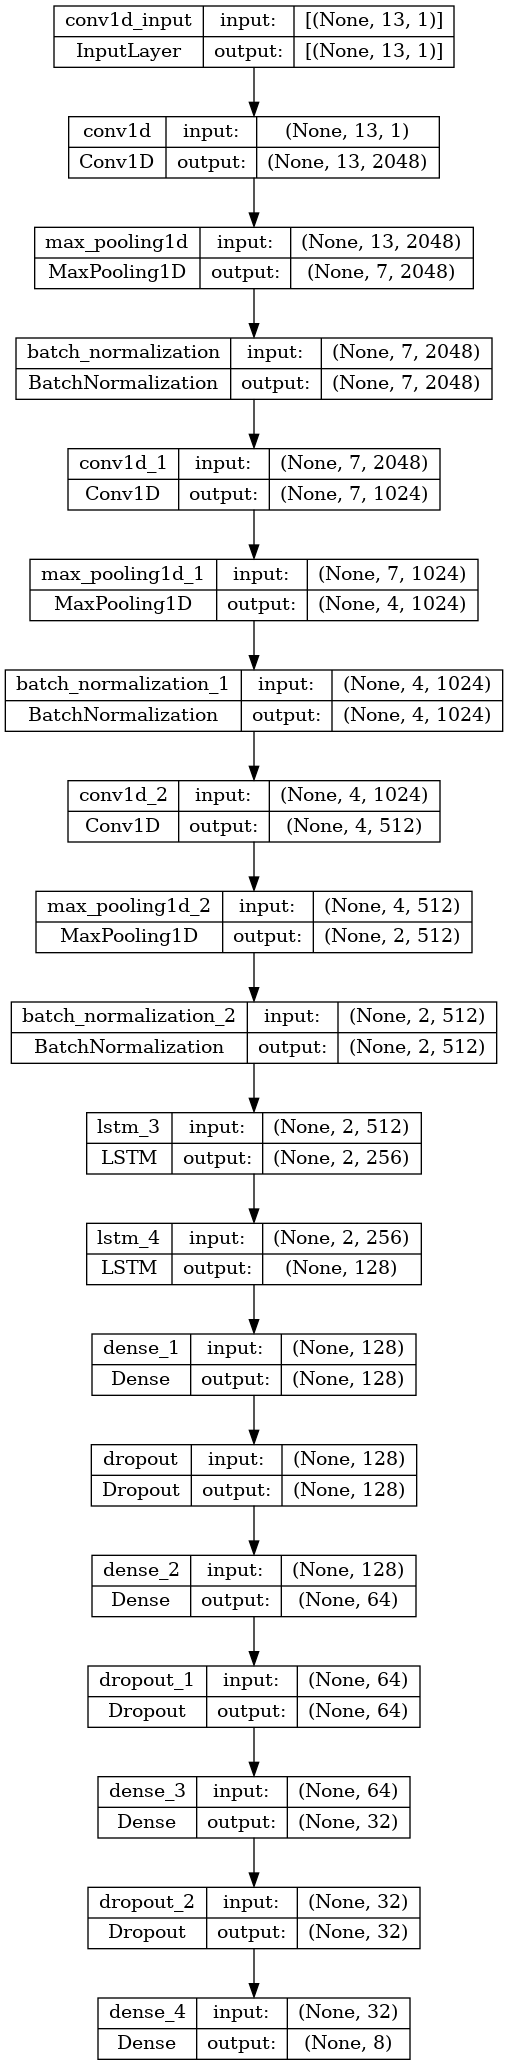

In [33]:
from keras.utils.vis_utils import plot_model
plot_model( model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [34]:
#CNN
history =  model.fit(x_traincnn, y_train, batch_size=64, epochs=800, validation_data=(x_testcnn, y_test))

Epoch 1/800
51/51 [==============================] - 16s 67ms/step - loss: 2.0530 - accuracy: 0.1642 - val_loss: 2.0883 - val_accuracy: 0.1259
Epoch 2/800
51/51 [==============================] - 1s 29ms/step - loss: 1.9896 - accuracy: 0.2127 - val_loss: 2.0600 - val_accuracy: 0.1361
Epoch 3/800
51/51 [==============================] - 1s 29ms/step - loss: 1.8676 - accuracy: 0.2725 - val_loss: 2.0119 - val_accuracy: 0.1620
Epoch 4/800
51/51 [==============================] - 1s 29ms/step - loss: 1.7794 - accuracy: 0.3170 - val_loss: 1.9849 - val_accuracy: 0.2019
Epoch 5/800
51/51 [==============================] - 2s 30ms/step - loss: 1.6833 - accuracy: 0.3534 - val_loss: 2.0863 - val_accuracy: 0.1787
Epoch 6/800
51/51 [==============================] - 1s 29ms/step - loss: 1.5634 - accuracy: 0.4114 - val_loss: 1.8823 - val_accuracy: 0.2361
Epoch 7/800
51/51 [==============================] - 1s 28ms/step - loss: 1.4579 - accuracy: 0.4546 - val_loss: 1.8959 - val_accuracy: 0.2056
Epoch

In [35]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

34/34 [==============================] - 1s 12ms/step - loss: 1.7089 - accuracy: 0.8046
Accuracy of our model on test data :  80.46296238899231 %


Some plots of multi_model
______________________________________________


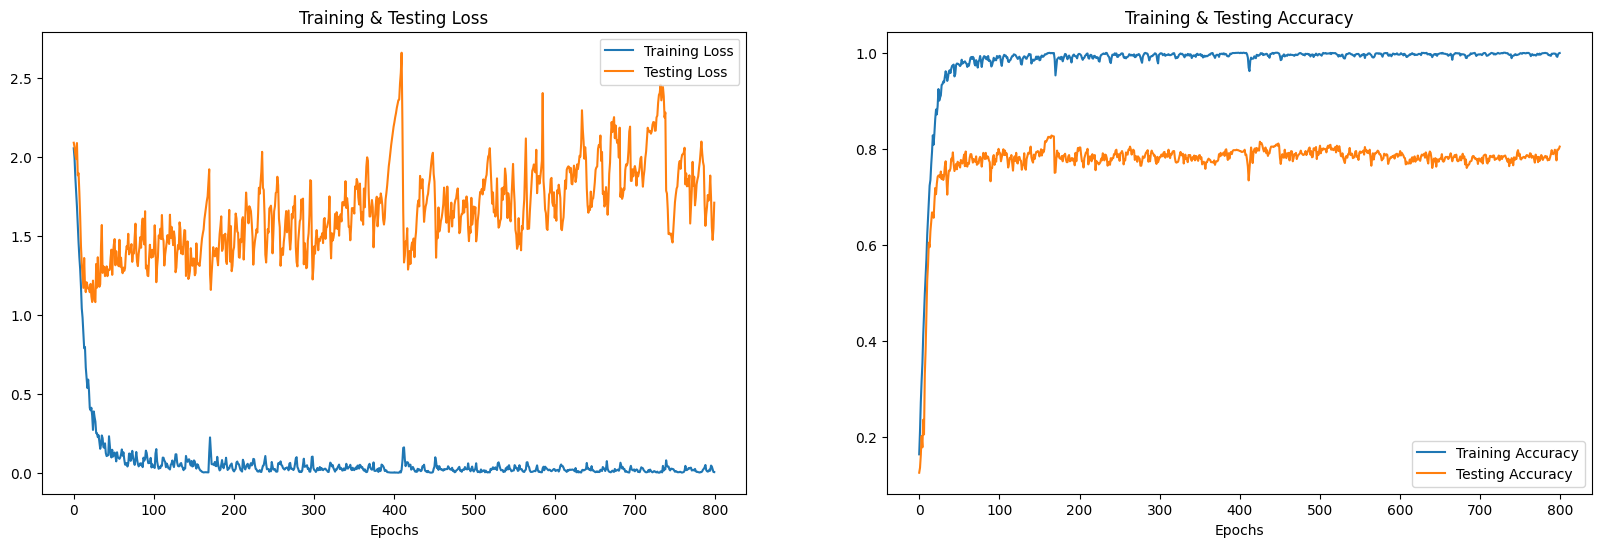

In [36]:
epochs = [i for i in range(800)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [37]:
# predicting on test data.
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test1 = encoder.inverse_transform(y_test)

# Check for random predictions
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test1.flatten()

df.head(10)


34/34 [==============================] - 1s 9ms/step


,Predicted Labels,Actual Labels
0,Fear,Fear
1,Surprise,Neutral
2,Sad,Sad
3,Neutral,Neutral
4,Fear,Fear
5,Angry,Angry
6,Surprise,Fear
7,Fear,Fear
8,Disgust,Disgust
9,Calm,Calm


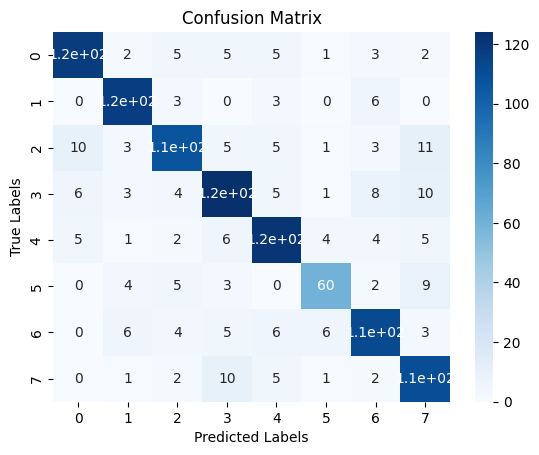

Overall Accuracy: 80.46%


In [40]:
cm = confusion_matrix(y_test1, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues")

# Add axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Calculate overall accuracy
accuracy = np.trace(cm) / np.sum(cm)
print("Overall Accuracy: {:.2f}%".format(accuracy*100))
